In [1]:
from google.colab import drive
## connecting to google colab
drive.mount('/content/drive')

Mounted at /content/drive


## Creating a subsection of the dataset, to save time
saving the random extracted images as chosen_images

## Getting the ground truth Json boxes

In [2]:
import os
import random
random.seed(42)
from PIL import Image
import json # Import the json module

def choose_random_images_and_json(folder_path, num_images):
    image_dict = {}  # Initialize an empty dictionary for images
    json_dict = {}  # Initialize an empty dictionary for JSON files

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        file_key = os.path.splitext(filename)[0]  # Extract base filename

        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image files
            try:
                with Image.open(file_path) as img:
                    image_dict[file_key] = file_path  # Add image to dictionary
            except IOError:
                pass  # Ignore non-image files

        elif filename.lower().endswith('.json'):  # Check for JSON files
            json_dict[file_key] = file_path  # Add JSON file to dictionary

    # Check if there are enough images in the folder
    if len(image_dict) < num_images:
        print(f"Warning: Only {len(image_dict)} images found in the folder. Returning all available images.")
        return image_dict, json_dict  # Return all available images and JSONs

    # Choose a random subset of images
    random_keys = random.sample(list(image_dict.keys()), num_images)

    # Create random image and JSON dictionaries
    random_images = {key: image_dict[key] for key in random_keys}
    random_jsons = {key: json_dict[key] for key in random_keys if key in json_dict}

    return random_images, random_jsons

chosen_images, chosen_jsons = choose_random_images_and_json("/content/drive/MyDrive/Aria_glasses/Datasets/Training_Set/Training_Set/Training_Set1/Training_Set1", 10)


# Print the chosen JSON file paths using the `.items()` method:
for file_name, json_path in chosen_jsons.items():
    print(f"File: {file_name}, JSON Path: {json_path}")

File: 4_Book6_33_out_20, JSON Path: /content/drive/MyDrive/Aria_glasses/Datasets/Training_Set/Training_Set/Training_Set1/Training_Set1/4_Book6_33_out_20.json
File: 3_Book6_70_in_far_3, JSON Path: /content/drive/MyDrive/Aria_glasses/Datasets/Training_Set/Training_Set/Training_Set1/Training_Set1/3_Book6_70_in_far_3.json
File: 3_Book6_64_in_far_30, JSON Path: /content/drive/MyDrive/Aria_glasses/Datasets/Training_Set/Training_Set/Training_Set1/Training_Set1/3_Book6_64_in_far_30.json
File: 2_Book6_82_in_close_3, JSON Path: /content/drive/MyDrive/Aria_glasses/Datasets/Training_Set/Training_Set/Training_Set1/Training_Set1/2_Book6_82_in_close_3.json
File: 2_Book2_45_in_close_18, JSON Path: /content/drive/MyDrive/Aria_glasses/Datasets/Training_Set/Training_Set/Training_Set1/Training_Set1/2_Book2_45_in_close_18.json
File: 3_Book2_294_in_far_75, JSON Path: /content/drive/MyDrive/Aria_glasses/Datasets/Training_Set/Training_Set/Training_Set1/Training_Set1/3_Book2_294_in_far_75.json
File: 3_Book2_26

In [3]:
def extract_bounding_boxes(json_file_path):
    # Read the JSON file
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    # Extract bounding box coordinates
    bounding_boxes = []
    # Check if data is a list and iterate accordingly
    for item in data if isinstance(data, list) else data.values():
        box = item.get('bounding_box', {})
        coordinates = (box.get('x', 0), box.get('y', 0), box.get('w', 0), box.get('h', 0))
        bounding_boxes.append(coordinates)

    return bounding_boxes


In [4]:
import os
import cv2

def getBoxCoordinatesFromJson(jsons):
    jsonBoxes = {}
    # Loop over every image in the folder
    for json, json_path in jsons.items():
            jsonBoxes[json] = extract_bounding_boxes(json_path)
    return jsonBoxes


json_boxes = getBoxCoordinatesFromJson( chosen_jsons )

for box, coordinates in json_boxes.items():
    print(f"Box: {box}, Coordinates: {coordinates}")

Box: 4_Book6_33_out_20, Coordinates: [(1934, 1159, 58, 94), (1475, 1442, 29, 29), (1504, 1437, 52, 27), (1553, 1446, 8, 21), (1565, 1433, 31, 29), (1597, 1431, 39, 29), (1639, 1425, 29, 29), (1672, 1425, 60, 27), (1735, 1412, 73, 36), (1815, 1416, 56, 27), (1871, 1406, 37, 29), (1909, 1398, 46, 29), (1959, 1391, 87, 31), (2045, 1387, 14, 31), (1479, 1483, 29, 31), (1507, 1479, 77, 29), (1586, 1477, 10, 27), (1597, 1473, 31, 31), (1628, 1469, 64, 27), (1697, 1467, 29, 31), (1729, 1461, 46, 29), (1777, 1454, 27, 31), (1806, 1458, 37, 29), (1842, 1446, 46, 29), (1894, 1440, 46, 29), (1940, 1435, 10, 27), (1534, 1519, 69, 25), (1605, 1511, 33, 29), (1641, 1507, 43, 35), (1687, 1502, 90, 33), (1783, 1498, 33, 27), (1817, 1492, 35, 27), (1852, 1484, 62, 33), (1917, 1484, 48, 27), (1966, 1477, 37, 27), (2006, 1469, 46, 27), (2052, 1460, 20, 29), (2073, 1460, 8, 31), (2085, 1460, 37, 27), (1484, 1557, 65, 27), (1551, 1557, 52, 20), (1609, 1544, 79, 33), (1693, 1546, 25, 25), (1722, 1540, 64, 2

## Running East with no pre processing

In [5]:
import cv2
import time
import numpy as np
from imutils.object_detection import non_max_suppression
from google.colab.patches import cv2_imshow

def applyEast(image, preprocessing = None):
    # Load the image
    orig = image.copy()
    (H, W) = image.shape[:2]

    # Calculate new dimensions divisible by 32
    newW = (W // 32) * 32  # Round down to nearest multiple of 32
    newH = (H // 32) * 32  # Round down to nearest multiple of 32

    # Save the aspect ratio
    rW = W / float(newW)
    rH = H / float(newH)

    #resize the image with the new W and H
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    if preprocessing:
      image = preprocessing(image)

    # Load EAST text detector
    net = cv2.dnn.readNet("/content/drive/MyDrive/Aria_glasses/Algorithms/frozen_east_text_detection.pb")
    layerNames = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]

    # Convert the image to a blob and perform forward pass
    #second parameter is the scale factor of the blob apparently this is better for east
    blob = cv2.dnn.blobFromImage(image, 1, (W, H),
                                 (123.68, 116.78, 103.94), swapRB=True, crop=False)
    start = time.time()
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    end = time.time()

    #print(f"[INFO] Text detection took {end - start:.6f} seconds")

    # Process the EAST output
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(numCols):
            if scoresData[x] < 0.5:
                continue

            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            angle = anglesData[x]
            cos, sin = np.cos(angle), np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # Apply non-maxima suppression
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    # Loop over detected text boxes
    for box in boxes:
        startX, startY, endX, endY = box

        # Extract the text region
        text_region = orig[startY:endY, startX:endX]

        # Convert to grayscale for OCR
        gray_text_region = cv2.cvtColor(text_region, cv2.COLOR_BGR2GRAY)


        # Draw the bounding box and recognized text
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

    #cv2_imshow(orig)

    return boxes

In [6]:
import os
import cv2

def runEastOnAllImagesInDictionaryAndCollectBoxes(images, pre_processing = None):
  images_boxes = {}
  for image_name, image_path in images.items():
            image = cv2.imread(image_path)
            if image is not None:
                print(f"Successfully read {image_name}")
                images_boxes[image_name] = applyEast(image, pre_processing)
            else:
                print(f"Failed to read {image_name}")
  return images_boxes


east_boxes = runEastOnAllImagesInDictionaryAndCollectBoxes(chosen_images)



Successfully read 4_Book6_33_out_20
Successfully read 3_Book6_70_in_far_3
Successfully read 3_Book6_64_in_far_30
Successfully read 2_Book6_82_in_close_3
Successfully read 2_Book2_45_in_close_18
Successfully read 3_Book2_294_in_far_75
Successfully read 3_Book2_268_in_far_32
Successfully read 2_Book6_32_in_close_3
Successfully read 5_Book6_34_in_ni_y_66
Successfully read 2_Book6_60_in_close_3


In [7]:
#converting the boxes from startx, starty, endx, endy to -> x, y, width, height
for imageName, boxes in east_boxes.items():
    east_boxes[imageName] = [[box[0], box[1], box[2] - box[0], box[3] - box[1]] for box in boxes]

In [8]:
def calculate_iou(box1, box2):
    # box1 and box2 should be in the format (x, y, width, height)
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate coordinates of the intersection rectangle
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)

    # Check for non-overlapping case
    if x_right <= x_left or y_bottom <= y_top:
        return 0.0

    # Calculate areas
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = w1 * h1
    box2_area = w2 * h2

    # Calculate union area
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area
    return iou

In [9]:
from scipy.optimize import linear_sum_assignment # Import the necessary function

def hungarian_matching(pred_boxes, gt_boxes, iou_threshold=0.5):
    # Create cost matrix using (1 - IoU) since we minimize cost
    cost_matrix = np.zeros((len(gt_boxes), len(pred_boxes)))

    for i, gt in enumerate(gt_boxes):
        for j, pred in enumerate(pred_boxes):
            iou = calculate_iou(gt, pred)
            cost_matrix[i, j] = 1 - iou

    # Solve with Hungarian algorithm
    gt_indices, pred_indices = linear_sum_assignment(cost_matrix)

    # Evaluate matches
    matches = []
    for i, j in zip(gt_indices, pred_indices):
        if 1 - cost_matrix[i, j] >= iou_threshold:
            matches.append((i, j, 1 - cost_matrix[i, j]))

    # Calculate metrics
    tp = len(matches)
    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

    return matches, precision, recall, f1_score

In [10]:
east_image_scores = {}

for imageName, boxes in east_boxes.items():
    matches, precision, recall, f1_score = hungarian_matching(boxes, json_boxes[imageName])
    east_image_scores[imageName] = [precision, recall, f1_score]


In [11]:
for imageName, scores in east_image_scores.items():
  print(f"Image: {imageName}, Precision: {scores[0]}, Recall: {scores[1]}, F1 Score: {scores[2]}")

Image: 4_Book6_33_out_20, Precision: 0.8472222222222222, Recall: 0.6853932584269663, F1 Score: 0.7577639751552795
Image: 3_Book6_70_in_far_3, Precision: 0.85, Recall: 0.12056737588652482, F1 Score: 0.2111801242236025
Image: 3_Book6_64_in_far_30, Precision: 0.9259259259259259, Recall: 0.5859375, F1 Score: 0.7177033492822966
Image: 2_Book6_82_in_close_3, Precision: 0.8333333333333334, Recall: 0.5335968379446641, F1 Score: 0.6506024096385542
Image: 2_Book2_45_in_close_18, Precision: 0.8385416666666666, Recall: 0.6491935483870968, F1 Score: 0.7318181818181817
Image: 3_Book2_294_in_far_75, Precision: 0.8333333333333334, Recall: 0.5485232067510548, F1 Score: 0.6615776081424936
Image: 3_Book2_268_in_far_32, Precision: 0.8908045977011494, Recall: 0.545774647887324, F1 Score: 0.6768558951965066
Image: 2_Book6_32_in_close_3, Precision: 0.881578947368421, Recall: 0.6261682242990654, F1 Score: 0.7322404371584699
Image: 5_Book6_34_in_ni_y_66, Precision: 0.797752808988764, Recall: 0.6698113207547169

In [12]:
def calculate_mean_scores(image_scores):
    precision_sum = 0
    recall_sum = 0
    f1_sum = 0
    count = 0

    for scores in image_scores.values():
        precision_sum += scores[0]
        recall_sum += scores[1]
        f1_sum += scores[2]
        count += 1

    mean_precision = precision_sum / count if count else 0
    mean_recall = recall_sum / count if count else 0
    mean_f1 = f1_sum / count if count else 0

    return mean_precision, mean_recall, mean_f1

# Example usage:
mean_precision, mean_recall, mean_f1 = calculate_mean_scores(east_image_scores)
print(f"Mean Precision: {mean_precision}")
print(f"Mean Recall: {mean_recall}")
print(f"Mean F1 Score: {mean_f1}")

Mean Precision: 0.8542648679695659
Mean Recall: 0.5635069013120919
Mean F1 Score: 0.6615073545602123


In [13]:
import cv2
import numpy as np

def calculate_mean_brightness(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.mean(gray_image)

def calculate_std_brightness(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.std(gray_image)

def calculate_global_luminance(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    return np.mean(hsv_image[:, :, 2])

def calculate_contrast(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_image.max() - gray_image.min()

In [14]:
# prompt: for every image in the east image scores, calculate the lmages brighteness scores using the functions above and save the filename and the scores in a dictionary
image_brightness_scores = {}

# Assuming you have a folder path with images
image_folder_path = "/content/drive/MyDrive/Aria_glasses/Datasets/Training_Set/Training_Set/Training_Set6/Training_Set6"  # Replace with your actual path

for image_name, image_path in chosen_images.items():
    image = cv2.imread(image_path)
    if image is not None:
        mean_brightness = calculate_mean_brightness(image)
        std_brightness = calculate_std_brightness(image)
        global_luminance = calculate_global_luminance(image)
        contrast = calculate_contrast(image)
        image_brightness_scores[image_name] = {
            "mean_brightness": mean_brightness,
            "std_brightness": std_brightness,
            "global_luminance": global_luminance,
            "contrast": contrast,
        }
    else:
        print(f"Could not read image: {image_name}")

#Print the results
for filename, scores in image_brightness_scores.items():
    print(f"File: {filename}")
    print(f"  Mean Brightness: {scores['mean_brightness']}")
    print(f"  Standard Deviation of Brightness: {scores['std_brightness']}")
    print(f"  Global Luminance: {scores['global_luminance']}")
    print(f"  Contrast: {scores['contrast']}")


File: 4_Book6_33_out_20
  Mean Brightness: 91.52240451388889
  Standard Deviation of Brightness: 59.689894335545084
  Global Luminance: 136.50131100501542
  Contrast: 255
File: 3_Book6_70_in_far_3
  Mean Brightness: 25.458818359375
  Standard Deviation of Brightness: 19.83776134267839
  Global Luminance: 38.364459514853394
  Contrast: 255
File: 3_Book6_64_in_far_30
  Mean Brightness: 74.29014467592593
  Standard Deviation of Brightness: 47.042006789423176
  Global Luminance: 100.40850489486883
  Contrast: 255
File: 2_Book6_82_in_close_3
  Mean Brightness: 49.51296694155093
  Standard Deviation of Brightness: 31.67240915465286
  Global Luminance: 72.17701509452161
  Contrast: 255
File: 2_Book2_45_in_close_18
  Mean Brightness: 89.14535095968364
  Standard Deviation of Brightness: 60.53648565486191
  Global Luminance: 129.71538628472223
  Contrast: 255
File: 3_Book2_294_in_far_75
  Mean Brightness: 88.06959466628086
  Standard Deviation of Brightness: 56.68348645602219
  Global Luminance

In [15]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def create_correlation_matrix_for_lighting_results(image_lighting_results, algorithm_error_rates, graph_title, perfomance_optic, perfomance_optic_str):
    data = []
    for image_name in image_lighting_results:
        data.append({
            'image_name': image_name,
            'mean_brightness': image_lighting_results[image_name]['mean_brightness'],  # Access using key 'mean_brightness'
            'std_brightness': image_lighting_results[image_name]['std_brightness'],  # Access using key 'std_brightness'
            'global_luminance': image_lighting_results[image_name]['global_luminance'],  # Access using key 'global_luminance'
            'contrast': image_lighting_results[image_name]['contrast'],  # Access using key 'contrast'
            'error_rate': algorithm_error_rates[image_name][perfomance_optic] # Assuming error_rate is the first element
        })

    # Create the Pandas DataFrame
    df = pd.DataFrame(data)

    # Calculate the correlation matrix
    correlation_matrix = df[['mean_brightness', 'std_brightness', 'global_luminance', 'contrast', 'error_rate']].corr()

    # Create the heatmap
    plt.figure(figsize=(10, 8))  # Adjust figure size if needed
    sns.heatmap(correlation_matrix, annot=True, cmap='ocean', fmt=".2f")
    plt.title(f"Correlation Matrix, lightings effect on {graph_title} {perfomance_optic_str}")
    plt.show()

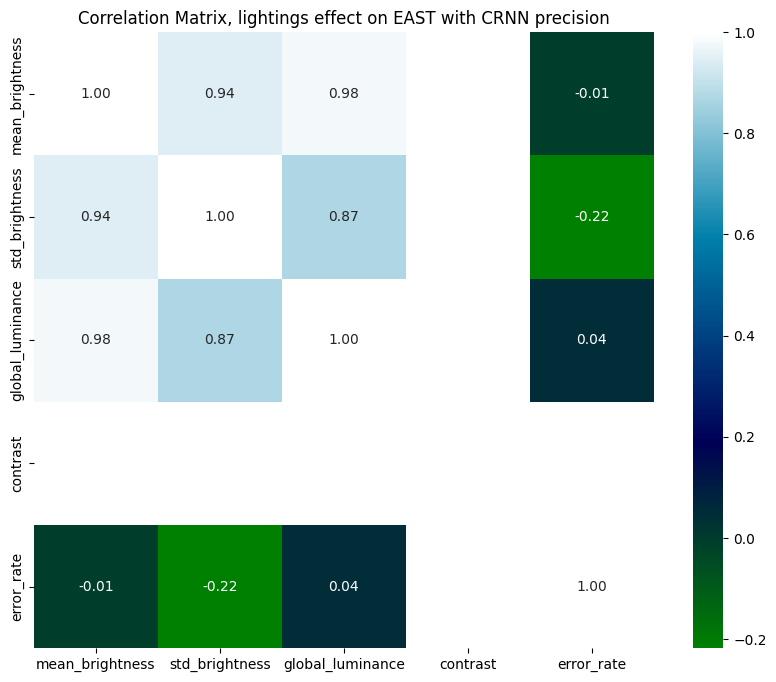

In [16]:
create_correlation_matrix_for_lighting_results( image_brightness_scores, east_image_scores, "EAST with CRNN",0, "precision" )

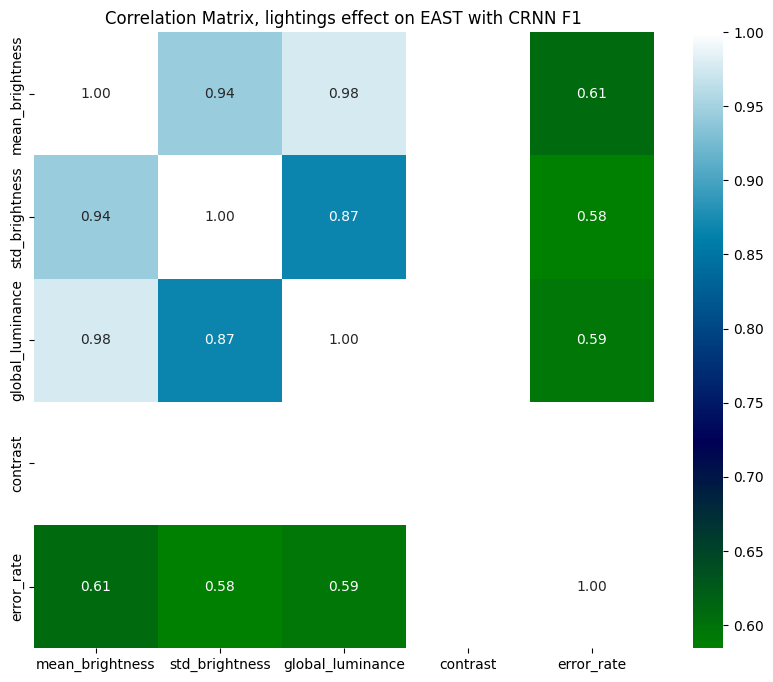

In [17]:
create_correlation_matrix_for_lighting_results( image_brightness_scores, east_image_scores, "EAST with CRNN",1, "F1" )

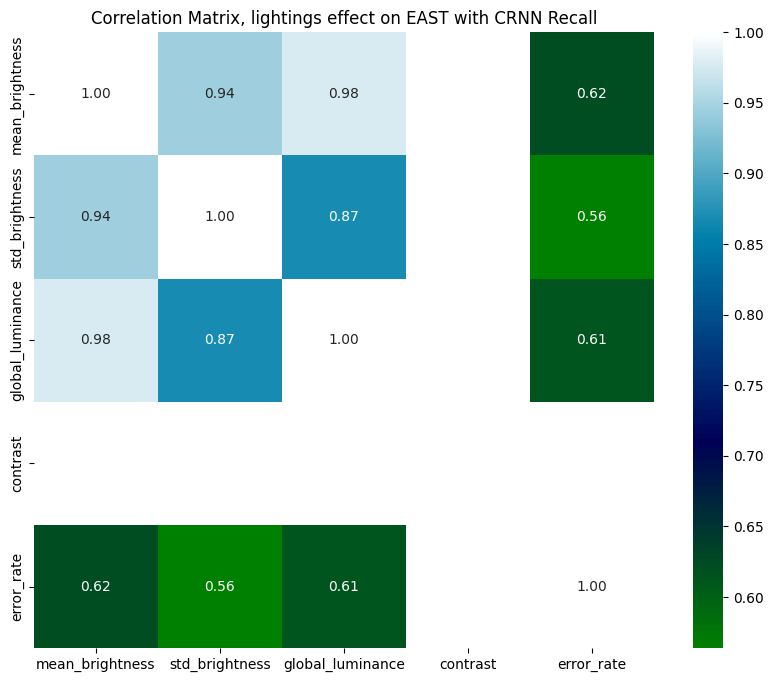

In [18]:
create_correlation_matrix_for_lighting_results( image_brightness_scores, east_image_scores, "EAST with CRNN",2, "Recall")

In [19]:
def pre_processing_clahe_1(image):
    # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(8,8))
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = clahe.apply(gray_image)
    print( "applying clahe 1 \n")
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    return image

def pre_processing_clahe_2(image):
    # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = clahe.apply(gray_image)
    print( "applying clahe 2 \n")
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    return image

def pre_processing_clahe_3(image):
      # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=4, tileGridSize=(8,8))
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = clahe.apply(gray_image)
    print( "applying clahe 3 \n")
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    return image


def pre_processing_clahe_4(image):
      # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=4, tileGridSize=(8,8))
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = clahe.apply(gray_image)
    print( "applying clahe 4 \n")
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    return image

def pre_processing_clahe_5(image):
      # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(16,16))
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = clahe.apply(gray_image)
    print( "applying clahe 5 \n")
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    return image

def pre_processing_gamma_correction_1(image):
    gamma = 1.2  # Adjust this value for desired effect
    gamma_corrected = np.array(255*(image / 255) ** gamma, dtype = 'uint8')
    return gamma_corrected

def pre_processing_gamma_correction_2(image):
    gamma = 1.5  # Adjust this value for desired effect
    gamma_corrected = np.array(255*(image / 255) ** gamma, dtype = 'uint8')
    return gamma_corrected

def pre_processing_gamma_correction_3(image):
    gamma = 1.7  # Adjust this value for desired effect
    gamma_corrected = np.array(255*(image / 255) ** gamma, dtype = 'uint8')
    return gamma_corrected

def pre_processing_gamma_correction_4(image):
    gamma = 1.2  # Adjust this value for desired effect
    gamma_corrected = np.array(255*(image / 255) ** gamma, dtype = 'uint8')
    return gamma_corrected


def pre_processing_unsharpImage_1(image):
    # Apply Unsharp Masking
    gaussian_blurred = cv2.GaussianBlur(image, (5, 5), 0)
    unsharp_masked = cv2.addWeighted(image, 1, gaussian_blurred, -0.5, 0)
    return unsharp_masked

def pre_processing_unsharpImage_2(image):
    # Apply Unsharp Masking
    gaussian_blurred = cv2.GaussianBlur(image, (5, 5), 0)
    unsharp_masked = cv2.addWeighted(image, 1.5, gaussian_blurred, -0.5, 0)
    return unsharp_masked

def pre_processing_unsharpImage_3(image):
    # Apply Unsharp Masking
    gaussian_blurred = cv2.GaussianBlur(image, (5, 5), 0)
    unsharp_masked = cv2.addWeighted(image, 2, gaussian_blurred, -0.5, 0)
    return unsharp_masked

In [20]:
for imageName, image in chosen_images.items():
  print( f"image name: {imageName}")


image name: 4_Book6_33_out_20
image name: 3_Book6_70_in_far_3
image name: 3_Book6_64_in_far_30
image name: 2_Book6_82_in_close_3
image name: 2_Book2_45_in_close_18
image name: 3_Book2_294_in_far_75
image name: 3_Book2_268_in_far_32
image name: 2_Book6_32_in_close_3
image name: 5_Book6_34_in_ni_y_66
image name: 2_Book6_60_in_close_3


In [21]:
east_boxes_clahe_1= runEastOnAllImagesInDictionaryAndCollectBoxes(chosen_images,pre_processing_clahe_1)
east_boxes_clahe_2= runEastOnAllImagesInDictionaryAndCollectBoxes(chosen_images,pre_processing_clahe_2)
east_boxes_clahe_3 = runEastOnAllImagesInDictionaryAndCollectBoxes(chosen_images,pre_processing_clahe_3)
east_boxes_clahe_4= runEastOnAllImagesInDictionaryAndCollectBoxes(chosen_images,pre_processing_clahe_4)
east_boxes_clahe_5 = runEastOnAllImagesInDictionaryAndCollectBoxes(chosen_images,pre_processing_clahe_5)
east_boxes_gamma_1 = runEastOnAllImagesInDictionaryAndCollectBoxes(chosen_images,pre_processing_gamma_correction_1)
east_boxes_gamma_2 = runEastOnAllImagesInDictionaryAndCollectBoxes(chosen_images,pre_processing_gamma_correction_2)
east_boxes_gamma_3 = runEastOnAllImagesInDictionaryAndCollectBoxes(chosen_images,pre_processing_gamma_correction_3)
east_boxes_gamma_4 = runEastOnAllImagesInDictionaryAndCollectBoxes(chosen_images,pre_processing_gamma_correction_4)
east_boxes_unsharp_1 = runEastOnAllImagesInDictionaryAndCollectBoxes(chosen_images,pre_processing_unsharpImage_1)
east_boxes_unsharp_2 = runEastOnAllImagesInDictionaryAndCollectBoxes(chosen_images,pre_processing_unsharpImage_2)
east_boxes_unsharp_3 = runEastOnAllImagesInDictionaryAndCollectBoxes(chosen_images,pre_processing_unsharpImage_3)

# Create a list of all east_boxes dictionaries
all_east_boxes_dicts = [
    east_boxes_clahe_1,
    east_boxes_clahe_2,
    east_boxes_clahe_3,
    east_boxes_clahe_4,
    east_boxes_clahe_5,
    east_boxes_gamma_1,
    east_boxes_gamma_2,
    east_boxes_gamma_3,
    east_boxes_gamma_4,
    east_boxes_unsharp_1,
    east_boxes_unsharp_2,
    east_boxes_unsharp_3
]


Successfully read 4_Book6_33_out_20
applying clahe 1 

Successfully read 3_Book6_70_in_far_3
applying clahe 1 

Successfully read 3_Book6_64_in_far_30
applying clahe 1 

Successfully read 2_Book6_82_in_close_3
applying clahe 1 

Successfully read 2_Book2_45_in_close_18
applying clahe 1 

Successfully read 3_Book2_294_in_far_75
applying clahe 1 

Successfully read 3_Book2_268_in_far_32
applying clahe 1 

Successfully read 2_Book6_32_in_close_3
applying clahe 1 

Successfully read 5_Book6_34_in_ni_y_66
applying clahe 1 

Successfully read 2_Book6_60_in_close_3
applying clahe 1 

Successfully read 4_Book6_33_out_20
applying clahe 2 

Successfully read 3_Book6_70_in_far_3
applying clahe 2 

Successfully read 3_Book6_64_in_far_30
applying clahe 2 

Successfully read 2_Book6_82_in_close_3
applying clahe 2 

Successfully read 2_Book2_45_in_close_18
applying clahe 2 

Successfully read 3_Book2_294_in_far_75
applying clahe 2 

Successfully read 3_Book2_268_in_far_32
applying clahe 2 

Successfu

In [22]:
for east_boxes_dict in all_east_boxes_dicts:

      #converting the boxes from startx, starty, endx, endy to -> x, y, width, height
    for imageName, boxes in east_boxes_dict.items():
        east_boxes_dict[imageName] = [[box[0], box[1], box[2] - box[0], box[3] - box[1]] for box in boxes]

    east_box_image_score = {}

    for imageName, boxes in east_boxes_dict.items():
        matches, precision, recall, f1_score = hungarian_matching(boxes, json_boxes[imageName])
        east_box_image_score[imageName] = [precision, recall, f1_score]


    mean_precision, mean_recall, mean_f1 = calculate_mean_scores(east_box_image_score)


    print(f"Mean Precision: {mean_precision}")
    print(f"Mean Recall: {mean_recall}")
    print(f"Mean F1 Score: {mean_f1}")
    print("-----------------------------------------")

Mean Precision: 0.8337278859352331
Mean Recall: 0.6032014439565205
Mean F1 Score: 0.6970112796536062
-----------------------------------------
Mean Precision: 0.8225958730293256
Mean Recall: 0.5234764781432444
Mean F1 Score: 0.6356948292267601
-----------------------------------------
Mean Precision: 0.7388686430331564
Mean Recall: 0.36350617402821467
Mean F1 Score: 0.4816479574342677
-----------------------------------------
Mean Precision: 0.7388686430331564
Mean Recall: 0.36350617402821467
Mean F1 Score: 0.4816479574342677
-----------------------------------------
Mean Precision: 0.8231359185978555
Mean Recall: 0.5549167444748827
Mean F1 Score: 0.6584455252607941
-----------------------------------------
Mean Precision: 0.8405808641076173
Mean Recall: 0.5337846734223207
Mean F1 Score: 0.6338386795383715
-----------------------------------------
Mean Precision: 0.7852821267927346
Mean Recall: 0.46784143588839805
Mean F1 Score: 0.5669140254745936
--------------------------------------